Import Package

In [13]:
import random
import matplotlib.pyplot as plt
import urllib.request
import numpy as np

Load Data

In [34]:
def load_libsvm_from_url(url):
    response = urllib.request.urlopen(url)
    dataset = [line.decode('utf-8').strip().split() for line in response]
    data = np.zeros((len(dataset), 11))
    for i, line in enumerate(dataset):
        for part in line:
            index_value = part.split(":")
            if len(index_value) == 1:
                data[i, -1] = float(index_value[0])
            else:
                index, value = index_value
                data[i, int(index) - 1] = float(value)
    return data

C&RT Algorithm

In [35]:
class DecisionTreeCART:
    def __init__(self, max_depth=2000, min_size=1):
        self.max_depth = max_depth
        self.min_size = min_size
        self.root = None
    def fit(self, X, y):
        dataset = [X[i] + [y[i]] for i in range(len(X))]
        root = self._get_split(dataset)
        self._split(root, self.max_depth, self.min_size, 1)
        self.root = root
    def predict(self, row):
        return self._predict(self.root, row)
    def _calculate_squared_error(self, groups, classes):
        squared_error = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = sum([row[-1] for row in group]) / size
            squared_error += sum([(row[-1] - score)**2 for row in group])
        return squared_error
    def _test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    def _get_split(self, dataset):
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(dataset[0])-1):
            for row in dataset:
                groups = self._test_split(index, row[index], dataset)
                squared_error = self._calculate_squared_error(groups, None)
                if squared_error < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], squared_error, groups
        return {'index': b_index, 'value': b_value, 'groups': b_groups}
    def _to_terminal(self, group):
        if not group:
            return 0
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)
    def _split(self, node, max_depth, min_size, depth):
        if not node:
            return
        if 'groups' in node and node['groups']:
            left, right = node['groups']
            del(node['groups'])
        else:
            node['left'] = node['right'] = self._to_terminal([])
            return
        if len(left) == 0:
            node['left'] = self._to_terminal(right)
        else:
            if len(left) <= min_size or depth >= max_depth:
                node['left'] = self._to_terminal(left)
            else:
                node['left'] = self._get_split(left)
                self._split(node['left'], max_depth, min_size, depth + 1)
        if len(right) == 0:
            node['right'] = self._to_terminal(left)
        else:
            if len(right) <= min_size or depth >= max_depth:
                node['right'] = self._to_terminal(right)
            else:
                node['right'] = self._get_split(right)
                self._split(node['right'], max_depth, min_size, depth + 1)
    def _predict(self, node, row):
        if not node or 'index' not in node or node['index'] >= len(row):
            return 0
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict(node['right'], row)
            else:
                return node['right']

Random Forest

In [41]:
class RandomForest:
    def __init__(self, num_trees=1, sample_size_ratio=0.5):
        self.num_trees = num_trees
        self.sample_size_ratio = sample_size_ratio
        self.trees = []
    def fit(self, X, y):
        n_samples = len(X)
        for _ in range(self.num_trees):
            sample_size = int(n_samples * self.sample_size_ratio)
            indices = np.random.randint(0, n_samples, sample_size)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = DecisionTreeCART()
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    def calculate_eout(self, X, y):
        eouts = []
        for tree in self.trees:
            n_samples = len(X)
            sample_size = int(n_samples * self.sample_size_ratio)
            indices = np.random.randint(0, n_samples, sample_size)
            X_sample = X[indices]
            y_sample = y[indices]
            predictions = np.array([tree.predict(x) for x in X_sample])
            eout = np.mean((y_sample - predictions) ** 2)
            eouts.append(eout)
        return eouts

Data Ingesting

In [37]:
train_data = load_libsvm_from_url('http://www.csie.ntu.edu.tw/~htlin/course/ml23fall/hw6/hw6_train.dat')
test_data = load_libsvm_from_url('http://www.csie.ntu.edu.tw/~htlin/course/ml23fall/hw6/hw6_test.dat')
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

9

In [39]:
cart = DecisionTreeCART()
cart.fit(X_train, y_train)

In [42]:
random_forest = RandomForest()
random_forest.fit(X_train, y_train)
eouts = random_forest.calculate_eout(X_test, y_test)
eouts[0]

106.60245901639344

10

In [32]:
random_forest = RandomForest()
random_forest.fit(X_train, y_train)
eouts = random_forest.calculate_eout(X_test, y_test)

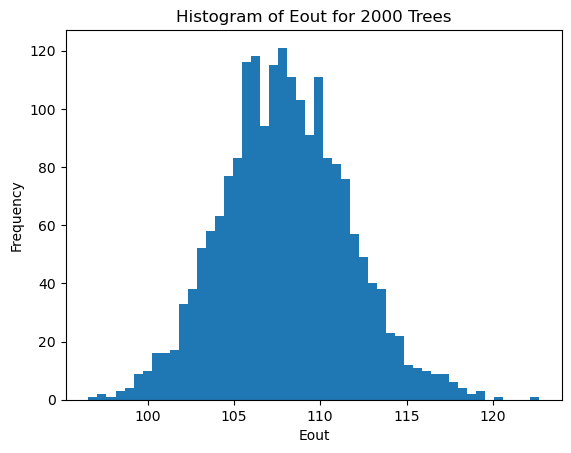

In [33]:
plt.hist(eouts, bins=50)
plt.xlabel('Eout')
plt.ylabel('Frequency')
plt.title('Histogram of Eout for 2000 Trees')
plt.show()